In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import numpy as np
import nest
import matplotlib.pyplot as plt
from matplotlib import rcParams 
import unicodeit
import ipywidgets as widgets
from ipywidgets import interact
import inspect
from joblib import Memory
from consts import Paths
from pathlib import Path
from os import makedirs
from dataclasses import dataclass

CACHE_DIR = Path(Paths.DATA_DIR) / 'myoga_cache'
makedirs(CACHE_DIR, exist_ok=True)

nest.set_verbosity('M_ERROR') 
figures = {}
memory = Memory(location=CACHE_DIR, verbose=0)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# utility functions
def time_max_voltage(x):
    return x["times"][np.argmax(x["V_m"])] * 100


def plot_axes_legend(ax):
    ax.set_xlabel("Time (ms)")
    ax.legend()
    ax.set_ylabel("V_m")


def plot_voltage(ax, data, color="b", label="", linewidth=1, plot_max=True):
    if plot_max:
        ax.axvline(time_max_voltage(data), color=color, linewidth=0.5)
    ax.plot(data["V_m"], color=color, linewidth=linewidth, label=label)


def plot_threshold(ax, level=-55):
    ax.axhline(-55, color="k", linestyle="--")

# MSO model
we'll just use the complete four input model as a basis, and create simpler model from here. since it's easy enough i think this is for the best

In [14]:
@dataclass
class ParamsMSO4:
    delay_exc_i: float = 5
    delay_exc_c: float = 5
    # delay_exc_i - delay_exc_c = ITD
    delay_inh_i: float = 5
    delay_inh_c: float = 5
    tone: int = 100
    tau_rise_exc: float = 0.2
    tau_rise_in: float = 0.2
    tau_decay_ex: float = 0.5
    tau_decay_in: float = 1.5
    weight_exc_i: float = 5
    weight_exc_c: float = 5
    weight_inh_i: float = -4
    weight_inh_c: float = -4
    I_ext: int = 0
    time_sim: int = 15
    v_th: int = -40
    c_mso: int = 1


@memory.cache
def mso(p: ParamsMSO4):
    nest.ResetKernel()
    nest.local_num_threads = 16
    nest.resolution = 0.01

    input = nest.Create(
        "spike_generator",
        params={
            "spike_times": np.around(np.arange(1, p.time_sim + 1, 1000 / p.tone), 2)
        },
    )
    mso = nest.Create(
        "iaf_cond_beta",
        params={
            "V_th": p.v_th,
            "C_m": p.c_mso,
            "tau_rise_ex": p.tau_rise_exc,
            "tau_rise_in": p.tau_rise_in,
            "tau_decay_ex": p.tau_decay_ex,
            "tau_decay_in": p.tau_decay_in,
            "I_e": p.I_ext,
        },
    )
    rec = nest.Create("multimeter", 1, {"record_from": ["V_m"], "interval": 0.01})

    nest.Connect(rec, mso, "all_to_all")
    nest.Connect(
        input, mso, "one_to_one", syn_spec={"weight": p.weight_exc_i, "delay": p.delay_exc_i}
    )
    nest.Connect(
        input, mso, "one_to_one", syn_spec={"weight": p.weight_exc_c, "delay": p.delay_exc_c}
    )
    nest.Connect(
        input, mso, "one_to_one", syn_spec={"weight": p.weight_inh_i, "delay": p.delay_inh_i}
    )
    nest.Connect(
        input, mso, "one_to_one", syn_spec={"weight": p.weight_inh_c, "delay": p.delay_inh_c}
    )
    nest.Simulate(p.time_sim)
    return rec.get("events")

def angle_to_itd(angle,w_head:int = 22,v_sound:int = 33000):
    delta_x = (w_head*np.sin(np.deg2rad(angle)))
    return round(1000*delta_x/v_sound,2)


In [15]:
def paramsMSO2(
    delta_t: float = 0.4, weight_inh: float = -4, weight_exc: float = 4, **kwargs
) -> ParamsMSO4:
    params = ParamsMSO4(weight_inh_i=weight_inh, weight_exc_i=weight_exc, **kwargs)
    params.delay_inh_i = params.delay_exc_i + delta_t
    params.weight_exc_c = 0
    params.weight_inh_c = 0
    return params

# single PSP sum
this shows we can move peak voltage times. i included a slider for the inhibitory weight to show that changing the synaptic weight impacts the size of the shift considerably. what does this mean?

interactive(children=(FloatSlider(value=-0.4, description='delta_t', max=1.0, min=-1.5), IntSlider(value=-4, d…

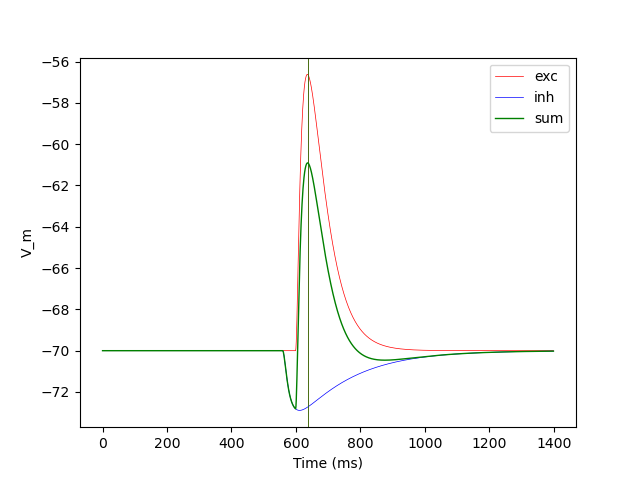

In [16]:
out = widgets.Output()


def show_mso_two_inputs(delta_t, weight_inh):
    # first run needs to create the plot
    my_name = inspect.currentframe().f_code.co_name
    if my_name not in figures.keys() or not figures[my_name][0].get_visible():
        figures[my_name] = plt.subplots(1, 1)
    fig, ax = figures[my_name]
    [l.remove() for l in ax.lines]

    only_ex = mso(paramsMSO2(delta_t=delta_t, weight_inh=0))
    only_inh = mso(paramsMSO2(delta_t=delta_t, weight_inh=weight_inh, weight_exc=0))
    res_sum = mso(paramsMSO2(delta_t=delta_t, weight_inh=weight_inh))
    plot_voltage(ax, only_ex, color="r", linewidth=0.5, label="exc")
    plot_voltage(ax, only_inh, color="b", linewidth=0.5, label="inh", plot_max=False)
    plot_voltage(ax, res_sum, color="g", linewidth=1, label="sum")
    plot_axes_legend(ax)
    print(
        unicodeit.replace(
            f"peak distance (t_{{no-inh}}-t_{{inh}}) = {time_max_voltage(only_ex) - time_max_voltage(res_sum)}"
        )
    )
    fig.show()
    p = paramsMSO2(delta_t=delta_t)
    print(
        f"ipsi exc -> {p.delay_exc_i}ms,\n     inh -> {p.delay_inh_i}ms"
    )


display(
    widgets.interactive(
        show_mso_two_inputs,
        delta_t=widgets.FloatSlider(min=-1.5, max=1, step=0.1, value=-0.4),
        weight_inh=widgets.IntSlider(min=-20, max=0, step=1, value=-4),
    )
)

# Three inputs

In [17]:
def paramsMSO3(
    angle: float = 0,
    deltat_inh: float = 0,  # delay_exc_c - delay_inh
    weight_inh: float = 0,
    **kwargs
):
    params = ParamsMSO4(**kwargs, weight_inh_c=0, weight_inh_i=weight_inh)
    itd = angle_to_itd(angle)
    params.delay_exc_c = params.delay_exc_i + itd
    params.delay_inh_i = params.delay_exc_i + deltat_inh
    return params

interactive(children=(IntSlider(value=0, description='angle', max=90, min=-90, step=15), FloatSlider(value=0.0…

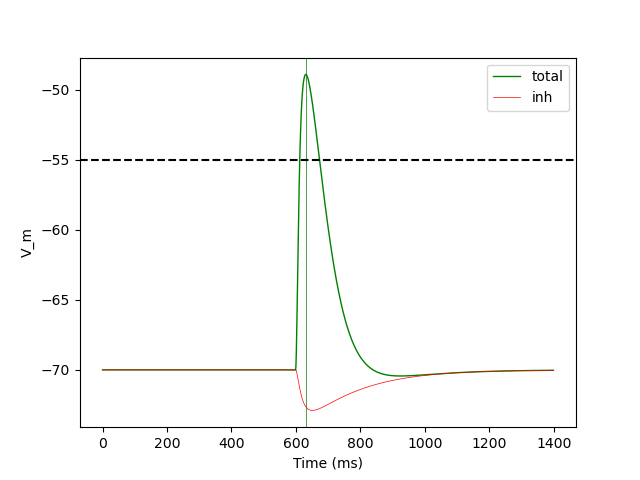

In [18]:
def show_mso_three_inputs(angle, deltat_inh, weight_inh):
    # first run needs to create the plot
    my_name = inspect.currentframe().f_code.co_name
    if my_name not in figures.keys() or not figures[my_name][0].get_visible():
        figures[my_name] = plt.subplots(1, 1)
    fig, ax = figures[my_name]
    [l.remove() for l in ax.lines]

    p = paramsMSO3(
        angle,
        deltat_inh=deltat_inh,
        weight_inh=weight_inh,
    )
    res_total = mso(p)
    only_inh = mso(paramsMSO2(weight_exc=0, delta_t=deltat_inh))
    plot_voltage(ax, res_total, "g", "total")
    plot_voltage(ax, only_inh, "r", "inh", linewidth=0.5,plot_max=False)
    plot_threshold(ax)
    plot_axes_legend(ax)
    print(
        f"ipsi exc -> {p.delay_exc_i}ms,\tcntr exc -> {p.delay_exc_c}ms,\n     inh -> {p.delay_inh_i}ms"
    )
    fig.show()


display(
    widgets.interactive(
        show_mso_three_inputs,
        angle=widgets.IntSlider(min=-90, max=90, step=15, value=0),
        deltat_inh=widgets.FloatSlider(min=-1.5, max=1, step=0.1),
        weight_inh=widgets.IntSlider(min=-15, max=0, step=1, value=-4),
    )
)

# Four inputs

In [19]:
def paramsMSO4(
    angle:float=0,
    deltat_inhi:float=0, # delay_exc_i - delay_inh_i
    deltat_inhc:float=0, # delay_exc_c - delay_inh_c
    **kwargs
):
    params=ParamsMSO4(**kwargs)
    itd = angle_to_itd(angle)
    params.delay_exc_c = params.delay_exc_i + itd
    params.delay_inh_i = params.delay_exc_i + deltat_inhi
    params.delay_inh_c = params.delay_exc_c + deltat_inhc
    return params

interactive(children=(IntSlider(value=0, description='angle', max=90, min=-90, step=15), FloatSlider(value=0.0…

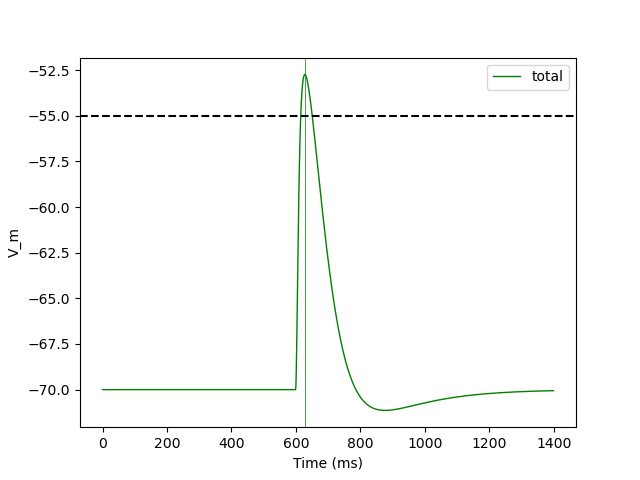

In [20]:
def show_mso_four_inputs(angle, deltat_inhi, deltat_inhc, weight_inh_i, weight_inh_c):
    # first run needs to create the plot
    my_name = inspect.currentframe().f_code.co_name
    if my_name not in figures.keys() or not figures[my_name][0].get_visible():
        figures[my_name] = plt.subplots(1, 1)
    fig, ax = figures[my_name]
    [l.remove() for l in ax.lines]
    p = paramsMSO4(
        angle,
        deltat_inhi,
        deltat_inhc,
        weight_inh_i=weight_inh_i,
        weight_inh_c=weight_inh_c,
    )
    res_total = mso(p)
    # res_only_inh = mso(paramsMSO4())
    plot_voltage(ax, res_total, "g", "total")
    plot_threshold(ax)
    plot_axes_legend(ax)
    print(
        f"ipsi exc -> {p.delay_exc_i}ms,\tcntr exc -> {p.delay_exc_c}ms,\nipsi inh -> {p.delay_inh_i}ms,\tcntr inh -> {p.delay_inh_c}ms"
    )
    fig.show()


display(
    widgets.interactive(
        show_mso_four_inputs,
        angle=widgets.IntSlider(min=-90, max=90, step=15, value=0),
        deltat_inhi=widgets.FloatSlider(min=-1.5, max=1, step=0.1),
        deltat_inhc=widgets.FloatSlider(min=-1.5, max=1, step=0.1),
        weight_inh_i=widgets.IntSlider(min=-15, max=0, step=1, value=-4),
        weight_inh_c=widgets.IntSlider(min=-15, max=0, step=1, value=-4),
    )
)